In [2]:
# Importando as bibliotecas utilizadas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
# bibliotecas utilizadas para o pré-processamento do texto

import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [70]:
# Módulos baixados com o download do nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords') 
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /home/ilan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ilan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ilan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ilan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ilan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [71]:
# Bibliotecas utilizadas na build

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [72]:
# Para vetorizar as palavras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
# Utilizada no embeding
import gensim
from gensim.models import Word2Vec

In [5]:
# Base de dados

df_train = pd.read_csv('./base-dados/train.csv')
df_test = pd.read_csv('./base-dados/test.csv')

0    4342
1    3271
Name: target, dtype: int64


/home/ilan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

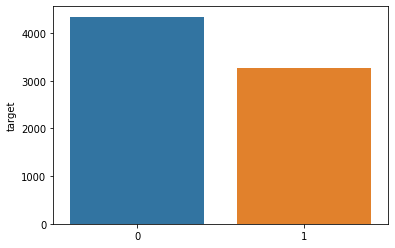

In [75]:
# Quantos itens possui cada classe

x = df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [76]:
# Tratando os campos vazios na tabela

df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [77]:
# Contador de palavras

df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969


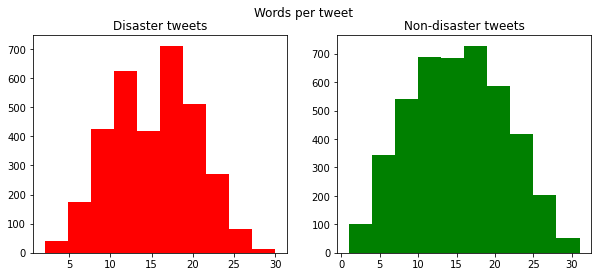

In [78]:
# Exibindo dois gráficos de palavras x tweets para os tweets
# pertencentes às duas classes
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [79]:
# Contador de caracteres

df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets

108.11342097217977
95.70681713496084


In [80]:
# Remove pontuações, converte letras maiúsculas pra minúsculas
# e faz o strip nas strings
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [81]:
# Remove palavras que não possuem relevância 
# para a classificação, como pronomes.

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [82]:
# "LEMMATIZATION"
# Reduz as palavras para formas mais básicas
# ex: information -> inform
wl = WordNetLemmatizer()

# Função auxiliar
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [84]:
# Converte para tokens

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [85]:
# Etapa final do pré-processamento

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


In [86]:
# Separando os dados de treino em dados de treino e teste

X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)

In [87]:
# Etapa do Word2Vec
# Utilizado nas palavras convertidas em tokens

X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [102]:
#Tf-Idf

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [116]:
# Criando um modelo Word2Vec

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [124]:
# Convertendo o texto para formato numérico com Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [118]:
# Ajustando o modelo de classificação com Regreção Logística (tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

LogisticRegression(C=10, solver='liblinear')

In [119]:
# Prevendo os valores de y nos datasets de teste
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       853
           1       0.77      0.71      0.74       670

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[710 143]
 [195 475]]
AUC: 0.839838323038967


In [123]:
# Ajustando o modelo de classificação com Regreção Logística (w2v)

lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

LogisticRegression(C=10, solver='liblinear')

In [125]:
# Prevendo os valores de y nos datasets de teste (w2v)

y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       853
           1       0.67      0.42      0.52       670

    accuracy                           0.65      1523
   macro avg       0.66      0.63      0.62      1523
weighted avg       0.66      0.65      0.64      1523

Confusion Matrix: [[711 142]
 [386 284]]
AUC: 0.7111415373309304


In [126]:
# Prevendo os valores de y nos datasets de teste (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

# Prevendo os valores de y nos datasets de teste
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       853
           1       0.67      0.42      0.52       670

    accuracy                           0.65      1523
   macro avg       0.66      0.63      0.62      1523
weighted avg       0.66      0.65      0.64      1523

Confusion Matrix: [[711 142]
 [386 284]]
AUC: 0.7111415373309304


In [127]:
# Pré-processamento do novo dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 

# Convertendo o texto para formato numérico com Word2Vec
X_vector=tfidf_vectorizer.transform(X_test)

# Usa o melhor modelo para prever a classe dos tweets do novo dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
final=df_test[['clean_text','target']].reset_index(drop=True)
print(final.head())


                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1
